# Finalised ridership analysis

Removed analysis involving multiple directions (since we decided to only analyse 1 direction for consistency)  
Saved some of the intermediate tables for plotting in the dashboard  
The function `get_hour_count_below_25th_percentile_each_stop` from here is reproduced in the streamlit app code  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
bus_routes = pd.read_json('../data/cleaned/BusRoutes.json', lines=True)
# bus_ridership_quarter = pd.read_csv('../data/cleaned/BusRideVolume_2024_070809.csv', dtype={'PT_CODE': int})
bus_routes_trips = pd.read_csv('../data/cleaned/bus_route_trips.csv')

Below filters for trip information to obtain 1 direction only and saves the file, loaded in again 2 cells down

In [3]:
# bus_routes_trips = bus_routes_trips[bus_routes_trips["Direction"] == 1]
# bus_routes_trips = bus_routes_trips.drop(columns=['Direction'])
# bus_routes_trips.to_csv('../data/cleaned/bus_route_trips_single_direction.csv', index=False)

Below saves the 3-month averages for each bus stop's ridership for each hour and the day category, next section just loads it in

In [4]:
# bus_ridership_quarter = bus_ridership_quarter.rename(columns={
#     'PT_CODE':'Destination_Stop'
# })

# aggregated_ridership = bus_ridership_quarter.groupby(['DAY_TYPE', 'TIME_PER_HOUR', 'PT_TYPE', 'Destination_Stop']).agg({
#     'TOTAL_TAP_IN_VOLUME': 'mean',
#     'TOTAL_TAP_OUT_VOLUME': 'mean'
# }).reset_index()

# aggregated_ridership.to_csv('../data/cleaned/aggregated_ridership.csv', index=False)

# ridership_percentiles = aggregated_ridership.groupby(['TIME_PER_HOUR', 'DAY_TYPE']).agg({
#     'TOTAL_TAP_IN_VOLUME': ['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
#     'TOTAL_TAP_OUT_VOLUME': ['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
# }).reset_index()
# ridership_percentiles.columns = ['TIME_PER_HOUR', 'DAY_TYPE', 'TAP_IN_MEAN', 'TAP_IN_25', 'TAP_IN_75', 'TAP_OUT_MEAN', 'TAP_OUT_25', 'TAP_OUT_75']

# ridership_percentiles.to_csv('../data/cleaned/ridership_percentiles.csv', index=False)

In [5]:
ridership = pd.read_csv('../data/cleaned/aggregated_ridership.csv')
ridership_percentiles = pd.read_csv('../data/cleaned/ridership_percentiles.csv')
bus_routes_trips = pd.read_csv('../data/cleaned/bus_route_trips_single_direction.csv')

In [8]:
def get_hour_count_below_25th_percentile_each_stop(bus_service, bus_routes_trips, ridership, ridership_percentiles):
    
    # filter bus_routes_trips to only include the chosen bus service
    chosen_bus_route_trips = bus_routes_trips[bus_routes_trips['ServiceNo'] == bus_service]
    total_num_stops = len(chosen_bus_route_trips["Destination_Stop"].unique())

    # merge chosen_bus_route_trips with ridership to get the estimated tap in and tap out
    chosen_route_ridership = chosen_bus_route_trips.merge(
        ridership,
        on=['Destination_Stop', 'PT_TYPE', 'TIME_PER_HOUR', 'DAY_TYPE'],
        how='left'
    )

    # calculate the estimated tap in and tap out based on estimated number of trips for the bus route
    chosen_route_ridership['Estimated_Tap_In'] = (chosen_route_ridership['Adj_Estimated_Trips'] *
                                                (chosen_route_ridership['TOTAL_TAP_IN_VOLUME'] / chosen_route_ridership['TOTAL_TRIPS']))
    chosen_route_ridership['Estimated_Tap_Out'] = (chosen_route_ridership['Adj_Estimated_Trips'] *
                                                (chosen_route_ridership['TOTAL_TAP_OUT_VOLUME'] / chosen_route_ridership['TOTAL_TRIPS']))

    # merge chosen_route_ridership with overall ridership_percentiles to get the 25th percentile tap in and tap out
    service_ridership_and_global_ridership = chosen_route_ridership.merge(
        ridership_percentiles,
        on=['TIME_PER_HOUR', 'DAY_TYPE']
    )

    # filter the bus stops to only include those with estimated tap in and tap out below the 25th percentile
    filtered_busstops = service_ridership_and_global_ridership[
        (service_ridership_and_global_ridership['Estimated_Tap_In'] < service_ridership_and_global_ridership['TAP_IN_25']) &
        (service_ridership_and_global_ridership['Estimated_Tap_Out'] < service_ridership_and_global_ridership['TAP_OUT_25']) &
        (service_ridership_and_global_ridership['TIME_PER_HOUR'] > 5) & (service_ridership_and_global_ridership['TIME_PER_HOUR'] < 23)
    ]

    # count the number of hours below the 25th percentile for each service stop
    num_hours_below_25th_by_service_stop = (
        filtered_busstops.groupby(['Destination_StopSequence', 'DAY_TYPE'])
        .size()
        .reset_index(name='Total_Hour_Count')
    )

    # create full index of all possible combinations of Destination_StopSequence and DAY_TYPE
    # this is because some bus stops may not have any hours below the 25th percentile and won't be included in the previous step
    max_sequence = filtered_busstops['Max_StopSequence'].max()
    day_types = filtered_busstops['DAY_TYPE'].unique()
    full_index = pd.MultiIndex.from_product(
        [range(1, int(max_sequence) + 1), day_types], 
        names=['Destination_StopSequence', 'DAY_TYPE']
    )

    # filling missing values with 0
    num_hours_below_25th_by_service_stop = num_hours_below_25th_by_service_stop.set_index(['Destination_StopSequence', 'DAY_TYPE']).reindex(full_index, fill_value=0).reset_index()
    
    return num_hours_below_25th_by_service_stop, total_num_stops

Run the function for 1 bus route

In [9]:
hour_count_by_stop_sequence, total_num_stops = get_hour_count_below_25th_percentile_each_stop('963', bus_routes_trips, ridership, ridership_percentiles)
print(f'Total number of stops: {total_num_stops}')
hour_count_by_stop_sequence

Total number of stops: 48


,Destination_StopSequence,DAY_TYPE,Total_Hour_Count
0,1,WEEKDAY,0
1,1,WEEKENDS/HOLIDAY,0
2,2,WEEKDAY,17
3,2,WEEKENDS/HOLIDAY,16
4,3,WEEKDAY,1
...,...,...,...
93,47,WEEKENDS/HOLIDAY,1
94,48,WEEKDAY,1
95,48,WEEKENDS/HOLIDAY,1
96,49,WEEKDAY,1


Below are functions defined for plotting the data produced above  
We also want to know what proportion of bus stops have a high number of low ridership hours - second function prints it

In [10]:
# Plotting function for both directions on the same graph
def plot_hour_distribution(hour_counts, threshold, title):
    weekday_data = hour_counts[hour_counts['DAY_TYPE'] == 'WEEKDAY']
    weekend_data = hour_counts[hour_counts['DAY_TYPE'] == 'WEEKENDS/HOLIDAY']

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharey=True)
    
    i=0

    axes.scatter(weekday_data['Destination_StopSequence'], weekday_data['Total_Hour_Count'], label=f"Weekday", marker='o')
    axes.scatter(weekend_data['Destination_StopSequence'], weekend_data['Total_Hour_Count'], label=f"Weekend", marker='o')

    axes.axhline(y=threshold, color='r', linestyle='-', label='Threshold')
    
    # Adding labels and title
    axes.set_xlabel("Bus Stop Sequence")
    axes.set_ylabel("Total Hour Count (Occurrences of 0-23)")
    axes.set_title(title)
    axes.legend()
    axes.grid(True)
    
    plt.tight_layout()
    plt.show()

def print_percentage_exceeding_threshold(hour_counts, total_num_stops, threshold):
    # Calculate total sequences and sequences exceeding threshold for each direction
    weekday_data = hour_counts[hour_counts['DAY_TYPE'] == 'WEEKDAY']
    num_hours_low_ridership_weekday = weekday_data.shape[0]
    exceeding_sequences_weekday = weekday_data[weekday_data['Total_Hour_Count'] > threshold].shape[0]
    percentage_exceed_weekday = (exceeding_sequences_weekday / total_num_stops) * 100 if num_hours_low_ridership_weekday else 0
    print(f"Percentage of stop sequences exceeding {threshold} (weekday): {percentage_exceed_weekday:.2f}%")
    
    
    weekend_data = hour_counts[hour_counts['DAY_TYPE'] == 'WEEKENDS/HOLIDAY']
    num_hours_low_ridership_weekend = weekend_data.shape[0]
    exceeding_sequences_weekend = weekend_data[weekend_data['Total_Hour_Count'] > threshold].shape[0]
    percentage_exceed_weekend = (exceeding_sequences_weekend / total_num_stops) * 100 if num_hours_low_ridership_weekend else 0
    print(f"Percentage of stop sequences exceeding {threshold} (weekend): {percentage_exceed_weekend:.2f}%")


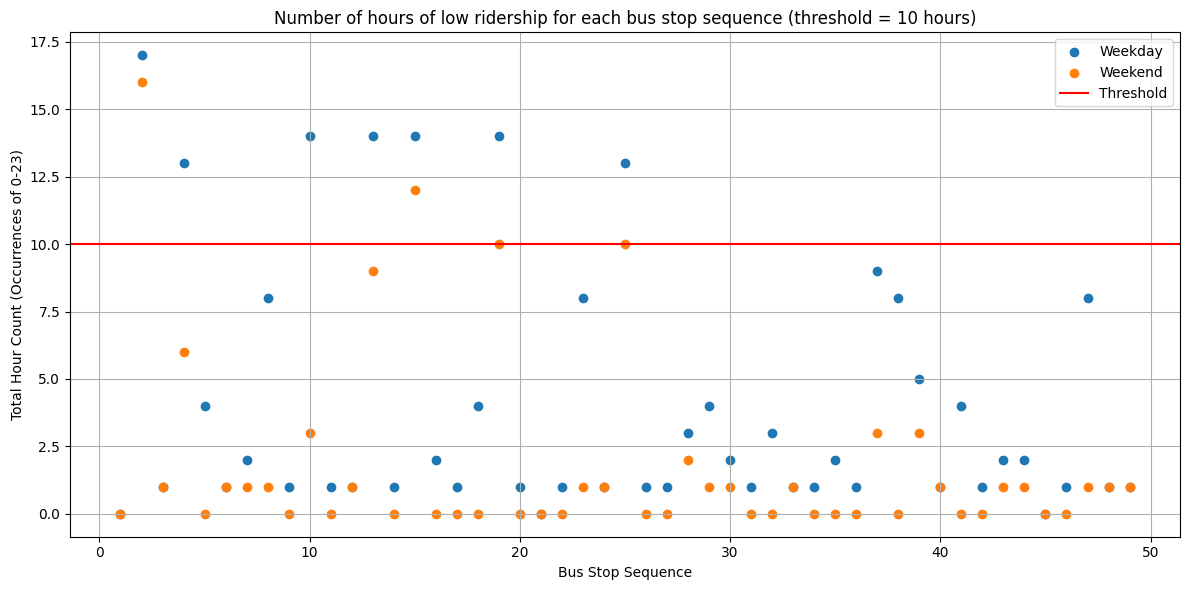

Percentage of stop sequences exceeding 10 (weekday): 14.58%
Percentage of stop sequences exceeding 10 (weekend): 4.17%


In [11]:
threshold = 10

plot_hour_distribution(hour_count_by_stop_sequence, 
                       10, 
                       "Number of hours of low ridership for each bus stop sequence (threshold = 10 hours)")
print_percentage_exceeding_threshold(hour_count_by_stop_sequence, total_num_stops, threshold)
